In [1]:
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize
import pandas as pd
import seaborn as sns
from datetime import datetime  
from datetime import timedelta
# import datetime

In [2]:
def giveMeData(df, prov):
    df_temp=df[df["Province/State"]==prov]
    array = df_temp.to_numpy()
    return array[0][5:]
def giveMeDataCountry(df, prov):
    df_temp=df[df["Country/Region"]==prov]
    array = df_temp.to_numpy()
    return array[0][5:]

In [3]:
def CanadaData(data, prov):
    #Returns np array of cases in a province 
    df=data
    df_temp=df[df["prname"]==prov]
    cases=df_temp["numconf"].to_numpy()
    # dt_temp_dates=df_temp["date"].to_numpy()
    return cases

def CanadaDatatests(data, prov):
    #Returns np array of tests in a province 
    df_temp=data[data["prname"]==prov]
    tests=df_temp["numtested"].to_numpy()
    # dt_temp_dates=df_temp["date"].to_numpy()
    return tests
#     return np.nan_to_num(cases)

def CanadaDataDeaths(data, prov):
    df=data
    df_temp=df[df["prname"]==prov]
    cases=df_temp["numdeaths"].to_numpy()
    # dt_temp_dates=df_temp["date"].to_numpy()
    return cases
#     return np.nan_to_num(cases)



In [4]:
def func(x, L, k, M):
    return ( L /( 1 + np.exp(-1 * k * ( x - M ))))

In [5]:
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c
def Linefunc(x, m, b):
    return m*x+b


# AUTOMATIC

In [6]:
date_start= datetime.strptime("01/22/20", "%m/%d/%y")
end_date = date_start + timedelta(days=72)
print (end_date.date())

2020-04-03


## CDF Fitting and testing rates

In [181]:

def MakeMePrediction(where,maxfev):
    print("\n\n------------- "+where+ "-------------")
#     rawData="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
#     data = pd.read_csv(rawData)
    canada_Data="https://health-infobase.canada.ca/src/data/covidLive/covid19.csv"
    data = pd.read_csv(canada_Data)
    
    dataName=where
#     ont=givemedata(data,where)
    ont=CanadaData(data,where)
    
    y_data = ont[0:].astype(float)
    x_data = np.arange(len(y_data)).astype(float)
    
    totaltested=CanadaDatatests(data,dataName)
    
    
    deaths=CanadaDataDeaths(data,dataName)
    death_dates=np.arange(0,len(deaths)).astype(float)
    
    deaths_10prec_proj=np.append(np.zeros(14),y_data*0.1)
    deaths_20prec_proj=np.append(np.zeros(14),y_data*0.2)

    delta_testes=np.diff(totaltested)[:] #total tested
    d_tested_dates=np.arange(0,len(delta_testes))


    
    
    #Fit model
    params, params_covariance = optimize.curve_fit(func, x_data, y_data,
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params1, params_covariance1 = optimize.curve_fit(func, x_data[0:-1], y_data[0:-1],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params3, params_covariance3 = optimize.curve_fit(func, x_data[0:-3], y_data[0:-3],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params5, params_covariance5 = optimize.curve_fit(func, x_data[0:-5], y_data[0:-5],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)
    params10, params_covariance10 = optimize.curve_fit(func, x_data[0:-10], y_data[0:-10],
                                                   p0=[4.451E5,0.1893,121.9],maxfev=9000)    
    param_ex, ex_cov = optimize.curve_fit(exponenial_func,x_data, y_data,
                                         p0=[100,0.01,-2000],maxfev=9000)

    #Out put raw data
#     print ("dates: ",x_data)
    print ("cases: ",y_data)
    #Calculate sigma
    sigma = np.sqrt(np.diag(params_covariance))
    sigma1 = np.sqrt(np.diag(params_covariance1))
#     print("-----")
#     print("params PY: ",params)
#     print("sigma PY: ", sigma)
    
#     #QA of data
#     plt.figure(figsize=(8, 6))
#     plt.title("Total number of cases for "+dataName+"!\n")
#     plt.scatter(x_data, y_data)
#     plt.plot(np.arange(len(y_data)),y_data)
#     plt.grid(alpha=0.2)
   

    #-------------------GAUSSIAN
    porjected_days=55
    
    delta_cases=np.diff(y_data)[:]
    delta_dates=np.arange(0,len(delta_cases)).astype(float)
    delta_x_future=np.arange(0,len(delta_cases)+porjected_days).astype(float)
    mean = sum(delta_dates * delta_cases) / sum(delta_cases)
    sigma_gfit = np.sqrt(sum(delta_cases * (delta_dates - mean)**2) / sum(delta_cases))
    popt,pcov   = curve_fit(Gauss, delta_dates, delta_cases, p0=[max(delta_cases), mean, sigma_gfit],maxfev=maxfev)
    popt1,pcov1 = curve_fit(Gauss, delta_dates[0:-1], delta_cases[0:-1], p0=[max(delta_cases[0:-1]), mean, sigma_gfit],maxfev=maxfev)
    popt2,pcov2 = curve_fit(Gauss, delta_dates[0:-2], delta_cases[0:-2], p0=[max(delta_cases[0:-2]), mean, sigma_gfit],maxfev=maxfev)
    popt3,pcov3 = curve_fit(Gauss, delta_dates[0:-3], delta_cases[0:-3], p0=[max(delta_cases[0:-3]), mean, sigma_gfit],maxfev=maxfev)
    popt4,pcov4 = curve_fit(Gauss, delta_dates[0:-4], delta_cases[0:-4], p0=[max(delta_cases[0:-4]), mean, sigma_gfit],maxfev=maxfev)
    popt5,pcov5 = curve_fit(Gauss, delta_dates[0:-5], delta_cases[0:-5], p0=[max(delta_cases[0:-5]), mean, sigma_gfit],maxfev=maxfev)
    popt6,pcov6 = curve_fit(Gauss, delta_dates[0:-6], delta_cases[0:-6], p0=[max(delta_cases[0:-6]), mean, sigma_gfit],maxfev=maxfev)
    popt7,pcov7 = curve_fit(Gauss, delta_dates[0:-7], delta_cases[0:-7], p0=[max(delta_cases[0:-7]), mean, sigma_gfit],maxfev=maxfev)
    popt8,pcov8 = curve_fit(Gauss, delta_dates[0:-8], delta_cases[0:-8], p0=[max(delta_cases[0:-8]), mean, sigma_gfit],maxfev=maxfev)
    popt9,pcov9 = curve_fit(Gauss, delta_dates[0:-9], delta_cases[0:-9], p0=[max(delta_cases[0:-9]), mean, sigma_gfit],maxfev=maxfev)

    x_pred_delta=np.arange(0,len(delta_cases)+porjected_days).astype(float)
    sigmaG = np.sqrt(np.diag(pcov))

    y_pred_plusG = Gauss(x_pred_delta, popt[0]+sigmaG[0], popt[1]+sigmaG[1], popt[2]+sigmaG[2])
    y_pred_minusG = Gauss(x_pred_delta, popt[0]-sigmaG[0], popt[1]-sigmaG[1], popt[2]-sigmaG[2])


    cases_in_14_days_higher = round(Gauss(delta_dates[-1]+14, popt[0]+sigmaG[0], popt[1]+sigmaG[1], popt[2]+sigmaG[2]))
    cases_in_14_days_lower = round( Gauss(delta_dates[-1]+14, popt[0]-sigmaG[0], popt[1]-sigmaG[1], popt[2]-sigmaG[2]))
    
    plt.figure(figsize=(12, 8))
    plt.title("new number of cases by day for "+where+"!\n"+"Estimated daily cases in 14 days: ~["+
              str(cases_in_14_days_higher)+", "+str(cases_in_14_days_lower)+"] (1σ)")
    plt.xlabel("Days from Day0(see note at top)\n"+last_updated)
    plt.ylabel("Cases")
    plt.scatter(delta_dates, delta_cases, label='data',alpha=0.9)
    plt.plot(delta_dates, delta_cases, alpha=0.2)
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt[0], popt[1], popt[2]),
                 label='Fitted function gauss', color='green')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt1[0], popt1[1], popt1[2]), alpha=0.4,
                 label='n-1')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt2[0], popt2[1], popt2[2]), alpha=0.4,
                 label='n-2')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt3[0], popt3[1], popt3[2]), alpha=0.4,
                 label='n-3')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt4[0], popt4[1], popt4[2]), alpha=0.4,
                 label='n-4')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt5[0], popt5[1], popt5[2]), alpha=0.4,
                 label='n-5')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt6[0], popt6[1], popt6[2]), alpha=0.4,
                 label='n-6')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt7[0], popt7[1], popt7[2]), alpha=0.4,
                 label='n-7')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt8[0], popt8[1], popt8[2]), alpha=0.4,
                 label='n-8')
    plt.plot(x_pred_delta, Gauss(x_pred_delta, popt9[0], popt9[1], popt9[2]), alpha=0.4,
                 label='n-9')
    plt.fill_between(x_pred_delta, y_pred_minusG,y_pred_plusG, alpha=0.3,label='1 Sigma on Signal')

    plt.grid(alpha=0.2)
    plt.vlines(x=delta_dates[-1]+14,colors='red',ymin=-10,ymax=np.max(delta_cases)+50, 
               label='14 days from last data point', alpha=0.75,linestyles="dashed")     # 2 weeks from now
    plt.legend(loc='best')
    plt.show()


    #-------------------MODEL!!!
    plt.figure(figsize=(12, 8))
    plt.xlabel("Days from Day0(see note at top)\n"+last_updated)
    plt.ylabel("Cases\n")
    plt.scatter(x_data, y_data, label='Data')
    plt.scatter(death_dates, deaths, label='Deaths', color='red',edgecolors='red', alpha=0.4)
    plt.plot(np.arange(len(deaths_10prec_proj)).astype(float), deaths_10prec_proj, label='10% Deaths projection', color='red', alpha=0.4)
    plt.plot(np.arange(len(deaths_20prec_proj)).astype(float), deaths_20prec_proj, label='20% Deaths projection', color='black', alpha=0.6)
    
    projected_days_m=30
    x_pred=np.arange(0,len(y_data)+projected_days_m).astype(float)
    x_future=np.arange(0,len(y_data)+projected_days_m).astype(float)
    days=0
    daysLP=days


#     print("----\nPY:")
    print("sigma+: "+ str(round(func(len(y_data)+days, params[0]+sigma[0], params[1]+sigma[1], params[2]-sigma[2]))))
    print("n+1: "+ str(round(func(len(y_data)+days, params[0], params[1], params[2]))))
    print("Sigma-: "+ str(round(func(len(y_data)+days, params[0]-sigma[0], params[1]-sigma[1], params[2]+sigma[2]))))
    print("----\n")
    print("params PY: ",params)
    print("PY sigma: ",sigma)
    print("max cases: ", round(params[0]))
    print("infection point: ", round(params[2]))
    date_start= datetime.strptime("01/31/20", "%m/%d/%y")
    infectionpoint = date_start + timedelta(days=round(params[2]))
    print ("infection point date: ",infectionpoint.date())


    y_pred_plus = func(x_future, params[0]+sigma[0], params[1]+sigma[1], params[2]-sigma[2])
    y_pred_minus = func(x_future, params[0]-sigma[0], params[1]-sigma[1], params[2]+sigma[2])
    plt.fill_between(x_future, y_pred_minus,y_pred_plus, alpha=0.3,label='1 Sigma on Signal')
    
    y_pred_plus1 = func(x_future, params1[0]+sigma1[0], params1[1]+sigma1[1], params1[2]-sigma1[2])
    y_pred_minus1 = func(x_future, params1[0]-sigma1[0], params1[1]-sigma1[1], params1[2]+sigma1[2])
    plt.fill_between(x_future, y_pred_minus1,y_pred_plus1, alpha=0.1,label='1 Sigma on n-1',color="c3")

    plt.plot(x_pred, func(x_pred, params[0], params[1], params[2]),
             label='Fitted function Py')
    plt.plot(x_pred, func(x_pred, params1[0], params1[1], params1[2]), alpha=0.7,
             label='1 Day ago')
    plt.plot(x_pred, func(x_pred, params3[0], params3[1], params3[2]), alpha=0.7,
             label='3 Days ago')
    plt.plot(x_pred, func(x_pred, params5[0], params5[1], params5[2]), alpha=0.7,
             label='5 Days ago')
    plt.plot(x_pred, func(x_pred, params10[0], params10[1], params10[2]), alpha=0.7,
             label='10 Days ago')
#     plt.plot(x_pred, exponenial_func(x_pred, param_ex[0], param_ex[1], param_ex[2]), alpha=0.7,
#              label='exponenial fit')
    
    plt.vlines(x=x_data[-1]+14,colors='red',ymin=-10,ymax=np.max(y_pred_plus)+100, 
               label='14 days from last data point', alpha=0.75,linestyles="dashed")     # 2 weeks from now
    plt.legend(loc='best')
    plt.tick_params(labelright=True)
    plt.grid(alpha=0.2)
#     plt.xlim(-10, 80)
#     plt.semilogy(basey=1)
#     plt.yscale('log')
    plt.title("Total number of cases for "+dataName+"!\n max cases: ~" + str(round(params[0])))# +"\n infection point date: ~"+str(infectionpoint.date()) )
    plt.show()
    
    
    #-------------------tests for cases-------------------

    x_pred_delta_tests=np.arange(0,len(delta_cases)+5).astype(float)

    tested_dates=np.arange(0,totaltested.size)
    valid = ~(np.isnan(tested_dates) | np.isnan(totaltested))
    popt_line_t, pcov_line_t = curve_fit(Linefunc, tested_dates[valid][0:-1], totaltested[valid][0:-1], p0=[ 1000, 10],maxfev=9000)
    popt_line_t_L7, pcov_line_t_L7 = curve_fit(Linefunc, tested_dates[valid][-8:-1], totaltested[valid][-8:-1], p0=[ 1000, 10],maxfev=9000)

    plt.figure(figsize=(12,8))
    plt.xlabel("Days from Day0(see note at top)\n"+last_updated)
    plt.ylabel("Tests\n")
    plt.title("Total test to day in "+dataName+"!\n"+"Rate: "+str(round(popt_line_t[0]))+" tests/day (cumulative)\n"
             +"Rate: "+str(round(popt_line_t_L7[0]))+" tests/day (last 7 days)\n"+
             "Precent of positive cases pre test:"+ str(round ((y_data[-1]/totaltested[-1])*100,3)) +"%" )
    plt.scatter(np.arange(0,totaltested.size),totaltested, label='data')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line_t[0], popt_line_t[1]), color="green",alpha=0.9, label='ploy1 fit')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line_t_L7[0], popt_line_t_L7[1]), alpha=0.6, label='last 7 days ploy1 fit ')
    plt.legend(loc='best')
    plt.grid(alpha=0.2,which='both')
    plt.show()
    #--
    valid = ~(np.isnan(d_tested_dates) | np.isnan(delta_testes))
    popt_line, pcov_line = curve_fit(Linefunc, d_tested_dates[valid][0:-1], delta_testes[valid][0:-1], p0=[ 1000, 10],maxfev=9000)
    popt_line_L7, pcov_line_L7 = curve_fit(Linefunc, d_tested_dates[valid][-8:-1], delta_testes[valid][-8:-1], p0=[ 1000, 10],maxfev=9000)

    plt.figure(figsize=(12, 8))
    plt.xlabel("Days from Day0(see note at top)\n"+last_updated)
    plt.ylabel("Tests\n")
    plt.title("Tests by day for "+dataName+"!\n"+"Rate: "+str(round(popt_line[0]))+" additional tests/day (cumulative)\n"
             +"Rate: "+str(round(popt_line_L7[0]))+" tests/day (last 7 days)\n"+
             "Precent of positive cases pre test:"+ str(round ((y_data[-1]/totaltested[-1])*100,3)) +"%" )
    plt.scatter( d_tested_dates,delta_testes, label='tests by day')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line[0], popt_line[1]), color="green",alpha=0.9, label='ploy1 fit')
    plt.plot(x_pred_delta_tests, Linefunc(x_pred_delta_tests, popt_line_L7[0], popt_line_L7[1]),alpha=0.6, label='last 7 days ploy1 fit ')
    plt.legend(loc='best')
    plt.grid(alpha=0.2,which='both')
    plt.show()
    
    print("Precent of positive cases pre test:", str(round ((y_data[-1]/totaltested[-1])*100,3)) ,"%" )

    

### The Cruve for everywhere

In [182]:
def TheCruve(AllofCanada,AllofCanadaAbv,maxfev):

    where="Ontario"

    canada_Data="https://health-infobase.canada.ca/src/data/covidLive/covid19.csv"
    data = pd.read_csv(canada_Data)

    plt.figure(figsize=(12, 8))
    plt.title("Daily cases by province\n AKA \"The Curve\"")
    plt.xlabel("Day from Day 0 of each data set (see note to the top)\n"+
              "Last updated: "+datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    plt.ylabel("Cases")
    porjected_days=55
    

    for i,where in enumerate(AllofCanada):
        ont=CanadaData(data,where)
        y_data = ont[0:].astype(float)
        x_data = np.arange(len(y_data)).astype(float)

        delta_cases=np.diff(y_data)[:]
        delta_dates=np.arange(0,len(delta_cases)).astype(float)
        delta_x_future=np.arange(0,len(delta_cases)+porjected_days).astype(float)
        mean = sum(delta_dates * delta_cases) / sum(delta_cases)
        sigma_gfit = np.sqrt(sum(delta_cases * (delta_dates - mean)**2) / sum(delta_cases))
        popt,pcov   = curve_fit(Gauss, delta_dates, delta_cases, p0=[max(delta_cases), mean, sigma_gfit],maxfev=maxfev)

        plt.scatter(delta_dates, delta_cases, alpha=0.3,
                    label='Data for '+AllofCanadaAbv[i])
        plt.plot(delta_x_future, Gauss(delta_x_future, popt[0], popt[1], popt[2]),
                 label='Gaus. '+AllofCanadaAbv[i])

#     plt.yscale('log')

#     plt.vlines(x=delta_dates[-1]+14,colors='red',ymin=0,ymax=np.max(delta_cases))
#     plt.show()
    plt.vlines(x=(len(CanadaData(data,'Canada')))+14,colors='red',ymin=-10,ymax=np.max(np.diff(CanadaData(data,'Canada'))[:])+50, 
               label='14 days from last data point', alpha=0.75, linestyles="dashed")     # 2 weeks from now
    plt.legend(loc='best')
    plt.show()


    plt.figure(figsize=(12, 8))
    plt.title("Normalized Daily cases by province\n AKA \"The Curve\"")
    plt.xlabel("Day from Day 0 of each data set (see note to the top)\n"+last_updated)
    plt.ylabel("Normalized Cases")

    for i,where in enumerate(AllofCanada):
        ont=CanadaData(data,where)
        y_data = ont[0:].astype(float)
        y_data = y_data / np.sqrt(np.sum(y_data**2))
        x_data = np.arange(len(y_data)).astype(float)

        delta_cases=np.diff(y_data)[:]
        delta_dates=np.arange(0,len(delta_cases)).astype(float)
        delta_x_future=np.arange(0,len(delta_cases)+porjected_days).astype(float)
        mean = sum(delta_dates * delta_cases) / sum(delta_cases)
        sigma_gfit = np.sqrt(sum(delta_cases * (delta_dates - mean)**2) / sum(delta_cases))
        popt,pcov   = curve_fit(Gauss, delta_dates, delta_cases, p0=[max(delta_cases), mean, sigma_gfit],maxfev=maxfev)

    #     plt.scatter(delta_dates, delta_cases, alpha=0.1,
    #                 label='Data for '+AllofCanadaAb[i])
        if where=="Canada":
            plt.plot(delta_x_future, Gauss(delta_x_future, popt[0], popt[1], popt[2]),
                     label='Gaus. '+AllofCanadaAbv[i],linewidth=4)        
        else:
            plt.plot(delta_x_future, Gauss(delta_x_future, popt[0], popt[1], popt[2]),
                     label='Gaus. '+AllofCanadaAbv[i],alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    print("The plot above shows total cases normalized to 1 for each province \n\n\n")
    
        

### Main calls

Last updated: 2020-05-04 23:25:53

    Waqar Muhammad - mwaqar@snolab.ca
    
    NOTE:
    All of the following was data is from Health Canada. 
    The CDF fit is a logicitsts curve fit. 
    The PDF fit is a simple gaussian fit. 
    Day 0 is:
    -> 31-01-2020 for Canada 
    -> 08-03-2020 for AB
    -> 31-01-2020 for BC
    -> 11-03-2020 for MN
    -> 11-03-2020 for NB
    -> 11-03-2020 for NL
    -> 11-03-2020 for NS
    -> 31-01-2020 for ON
    -> 11-03-2020 for PEI
    -> 01-03-2020 for QC
    -> 11-03-2020 for SW


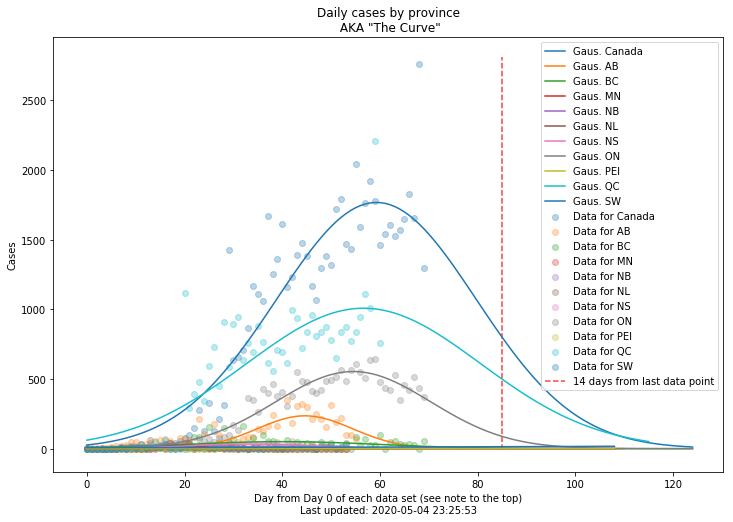

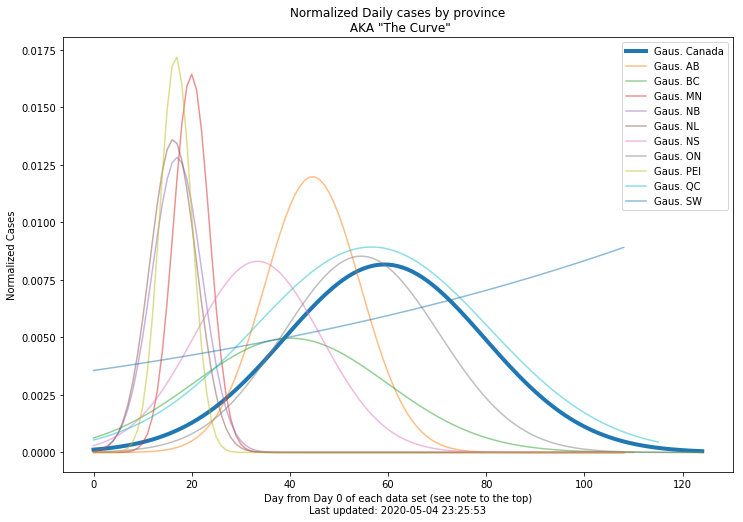

The plot above shows total cases normalized to 1 for each province 





------------- Canada-------------
cases:  [4.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.5000e+01 2.4000e+01 3.3000e+01 4.5000e+01
 5.1000e+01 5.7000e+01 6.2000e+01 7.7000e+01 1.0300e+02 1.3800e+02
 1.7600e+02 1.9300e+02 2.4900e+02 3.2400e+02 4.2400e+02 5.6900e+02
 8.4600e+02 9.7100e+02 1.3020e+03 1.4300e+03 1.6460e+03 1.9590e+03
 3.3850e+03 4.0180e+03 4.6750e+03 5.3860e+03 6.2550e+03 7.4240e+03
 8.5360e+03 9.5950e+03 1.1268e+04 1.2519e+04 1.3882e+04 1.5496e+04
 1.6653e+04 1.7883e+04 1.9274e+04 2.0748e+04 2.2133e+04 2.3301e+04
 2.4365e+04 2.5663e+04 2.7046e+04 2.8364e+04 3.0081e+04 3.1872e+04
 3.3341e+04 3.4777e+04 3.6823e+04 3.8413e+04 4.0179e+04 4.2099e+04
 4.3877e+04 4.5341e+04 4.6884e+04 4.8489e+04 5.0015e+04 5.1587e+04
 5.3236e+04 5.5061e+04 5.6714e+04 5.9474e+04 6.0772e+04]


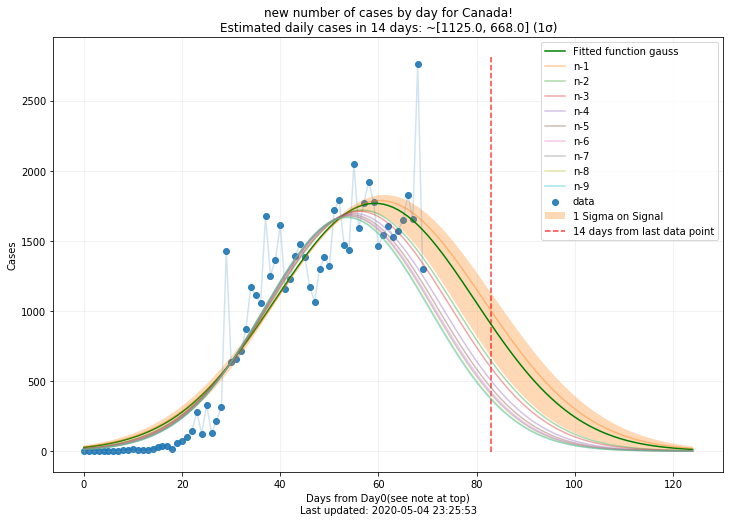

sigma+: 61509.0
n+1: 58989.0
Sigma-: 56466.0
----

params PY:  [6.85726387e+04 1.07668761e-01 5.41211836e+01]
PY sigma:  [1.76821117e+03 3.31591140e-03 6.08814849e-01]
max cases:  68573.0
infection point:  54.0
infection point date:  2020-03-25


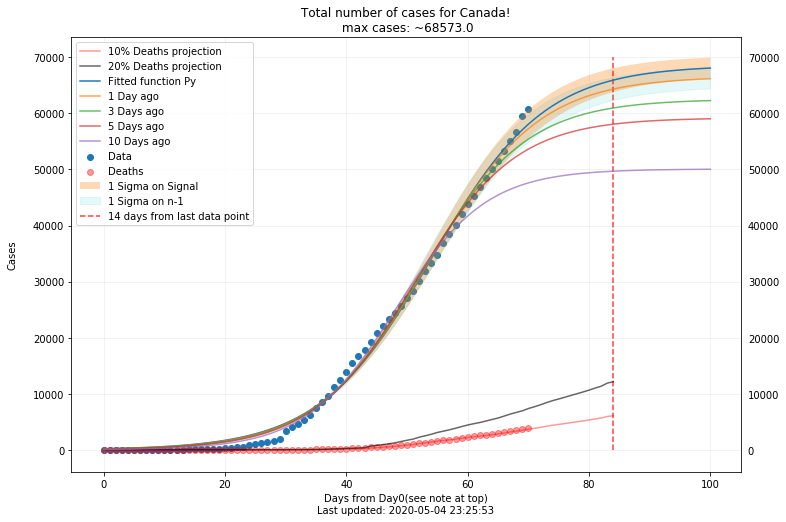

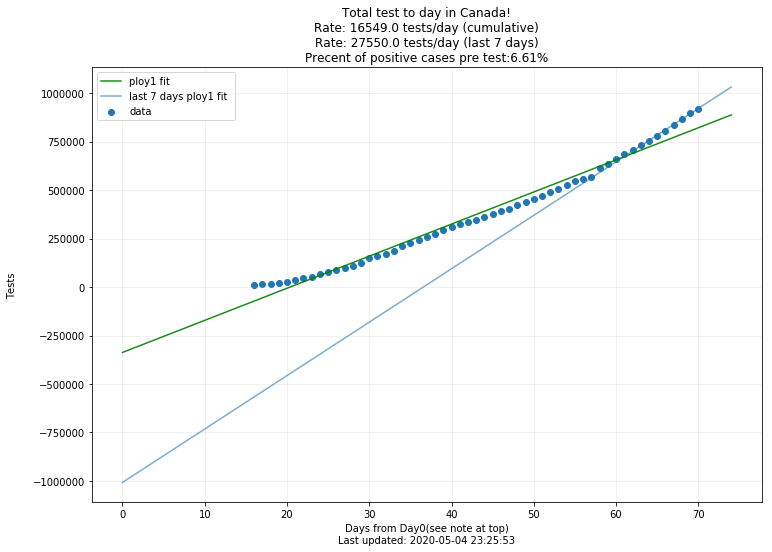

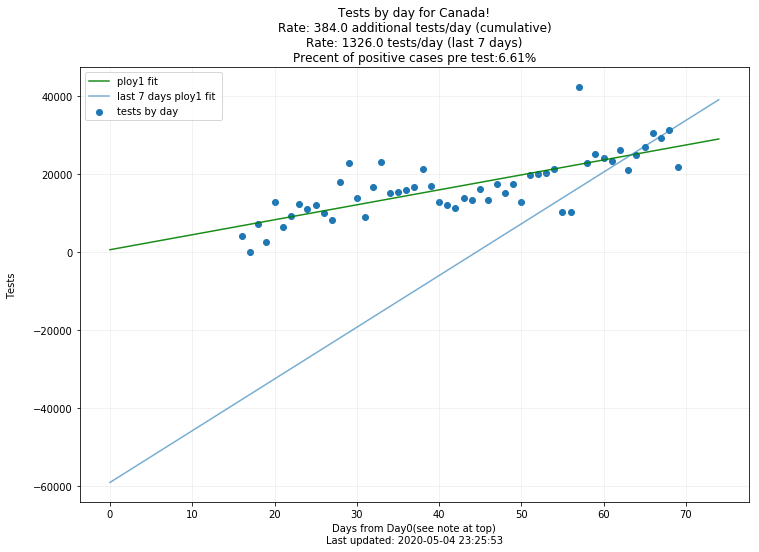

Precent of positive cases pre test: 6.61 %


------------- Alberta-------------
cases:  [1.000e+00 7.000e+00 1.400e+01 1.900e+01 2.300e+01 2.900e+01 3.900e+01
 5.600e+01 7.400e+01 9.700e+01 1.460e+02 1.950e+02 2.260e+02 2.590e+02
 3.010e+02 3.580e+02 4.190e+02 4.860e+02 5.420e+02 5.420e+02 6.210e+02
 6.900e+02 7.540e+02 7.540e+02 9.680e+02 1.075e+03 1.075e+03 1.250e+03
 1.348e+03 1.373e+03 1.423e+03 1.451e+03 1.500e+03 1.569e+03 1.651e+03
 1.732e+03 1.870e+03 1.996e+03 2.158e+03 2.397e+03 2.562e+03 2.562e+03
 2.908e+03 3.095e+03 3.401e+03 3.720e+03 4.017e+03 4.233e+03 4.480e+03
 4.696e+03 4.850e+03 5.165e+03 5.355e+03 5.573e+03 5.670e+03 5.766e+03
 5.836e+03]


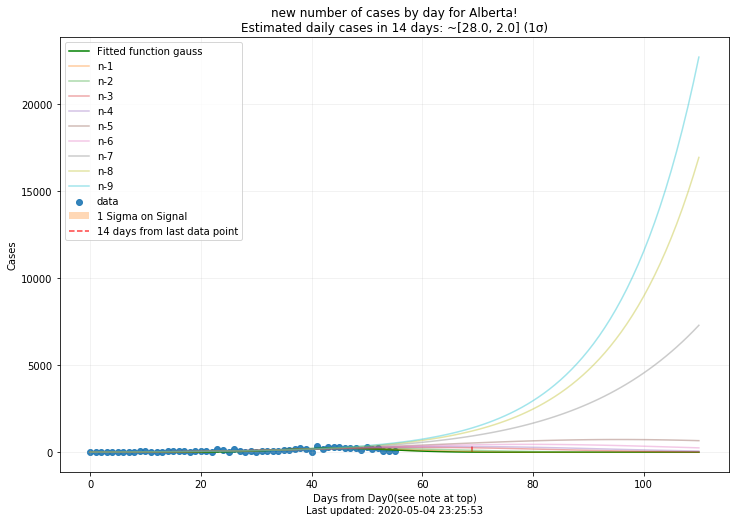

sigma+: 7208.0
n+1: 6334.0
Sigma-: 5524.0
----

params PY:  [1.00456641e+04 9.08938161e-02 5.11202515e+01]
PY sigma:  [7.23934428e+02 3.50965579e-03 1.59004186e+00]
max cases:  10046.0
infection point:  51.0
infection point date:  2020-03-22


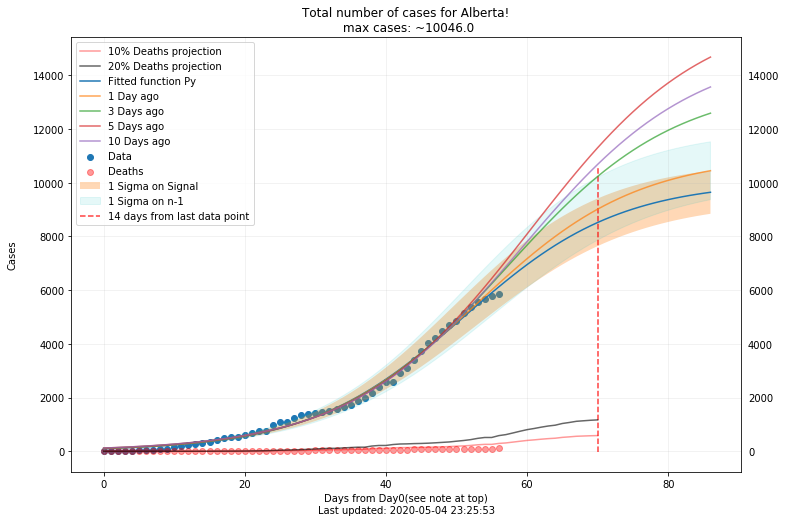

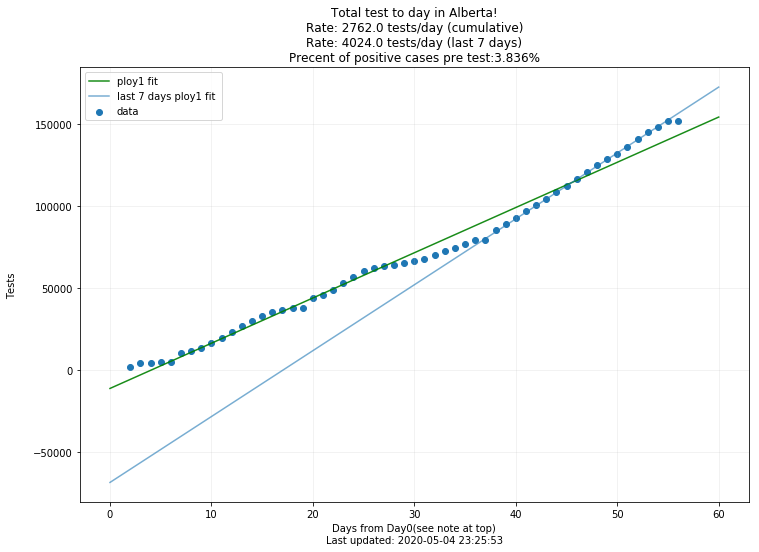

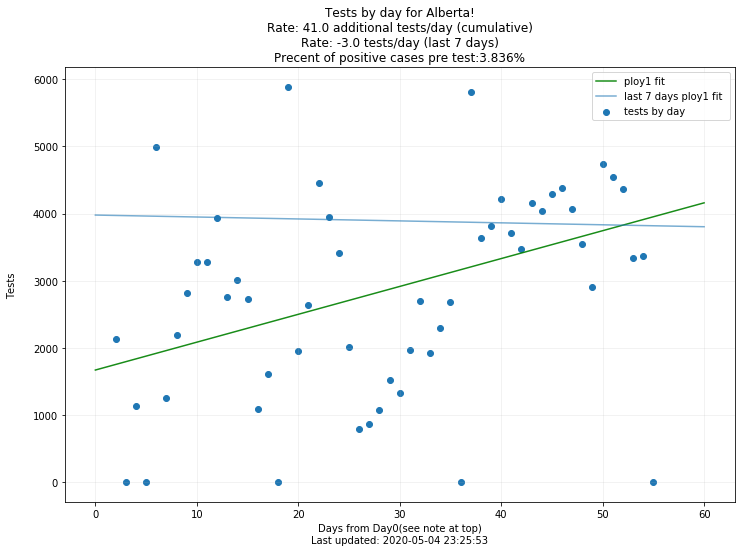

Precent of positive cases pre test: 3.836 %


------------- British Columbia-------------
cases:  [1.000e+00 4.000e+00 5.000e+00 6.000e+00 6.000e+00 7.000e+00 7.000e+00
 7.000e+00 7.000e+00 8.000e+00 1.200e+01 2.100e+01 2.100e+01 2.700e+01
 2.700e+01 3.200e+01 3.900e+01 4.600e+01 5.300e+01 6.400e+01 7.300e+01
 7.300e+01 1.030e+02 1.860e+02 2.710e+02 2.710e+02 4.240e+02 4.240e+02
 4.720e+02 6.170e+02 6.590e+02 7.250e+02 7.250e+02 8.840e+02 8.840e+02
 9.600e+02 9.700e+02 1.066e+03 1.121e+03 1.174e+03 1.203e+03 1.203e+03
 1.266e+03 1.291e+03 1.336e+03 1.370e+03 1.410e+03 1.445e+03 1.445e+03
 1.490e+03 1.517e+03 1.561e+03 1.561e+03 1.575e+03 1.618e+03 1.618e+03
 1.699e+03 1.724e+03 1.795e+03 1.824e+03 1.853e+03 1.948e+03 1.948e+03
 1.998e+03 2.053e+03 2.087e+03 2.112e+03 2.145e+03 2.171e+03 2.171e+03
 2.224e+03]


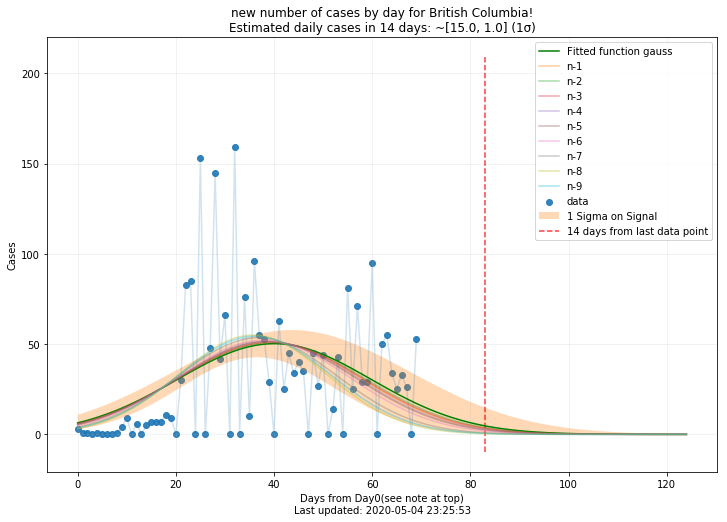

sigma+: 2104.0
n+1: 2045.0
Sigma-: 1983.0
----

params PY:  [2.10312530e+03 1.11317624e-01 3.90599301e+01]
PY sigma:  [4.63573614e+01 5.97561866e-03 6.68894371e-01]
max cases:  2103.0
infection point:  39.0
infection point date:  2020-03-10


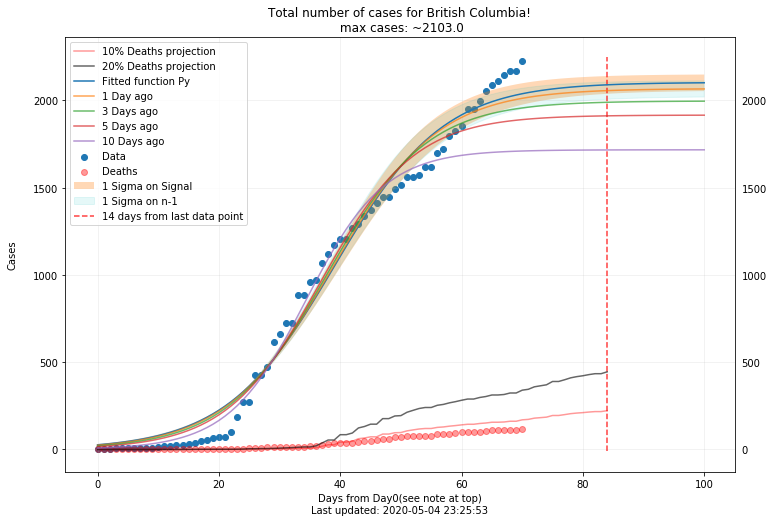

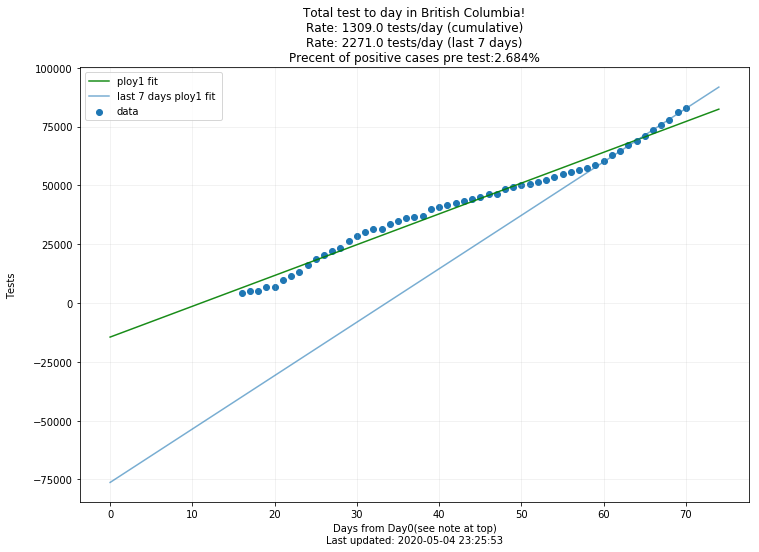

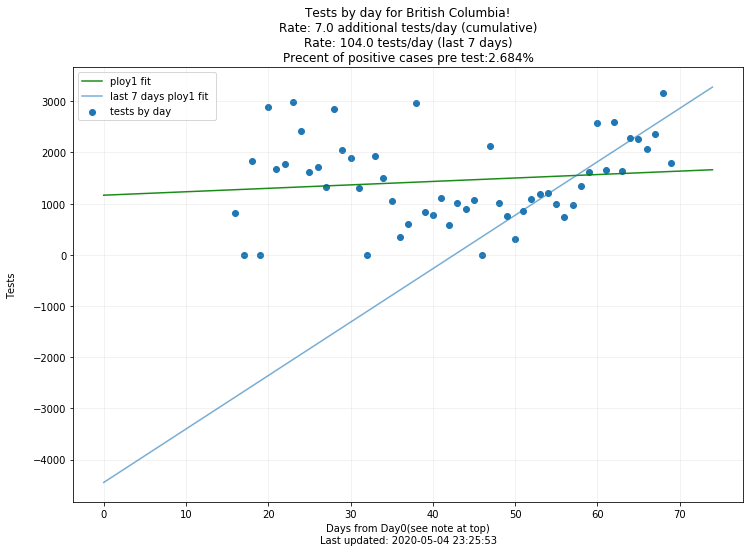

Precent of positive cases pre test: 2.684 %


------------- Manitoba-------------
cases:  [  0.   0.   1.   1.   4.   4.   7.   8.  17.  17.  11.  11.  11.  11.
  11.  11.  25.  25.  69.  83.  91. 109. 152. 164. 172. 187. 190. 203.
 206. 207. 215. 226. 226. 229. 229. 231. 239. 239. 243. 245. 246. 246.
 246. 251. 252. 256. 260. 261. 261. 263. 275. 279. 280. 281. 281.]


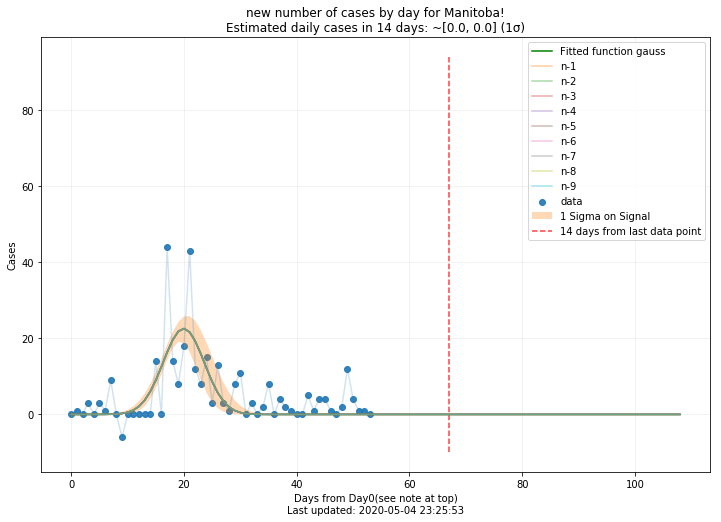

sigma+: 259.0
n+1: 256.0
Sigma-: 253.0
----

params PY:  [255.92180732   0.26963314  22.09637315]
PY sigma:  [2.94621995 0.01672474 0.2682956 ]
max cases:  256.0
infection point:  22.0
infection point date:  2020-02-22


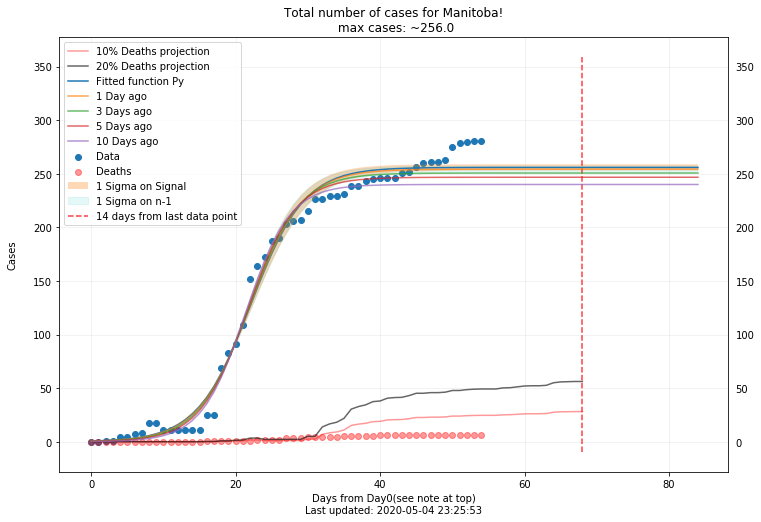

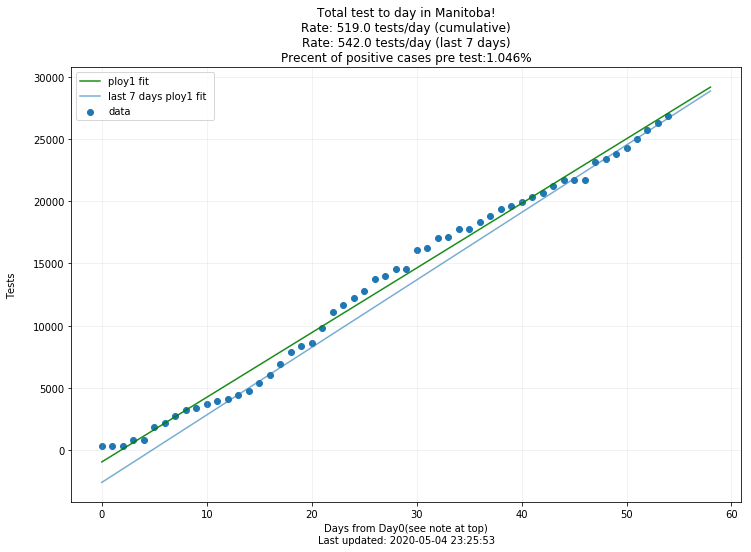

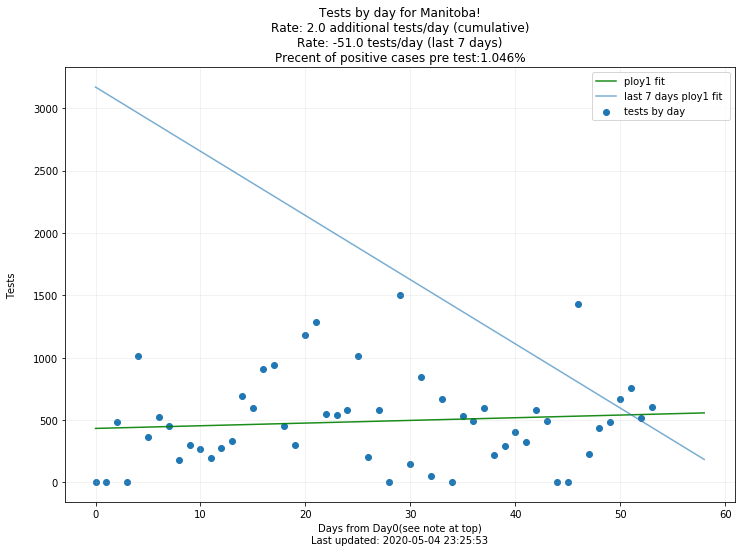

Precent of positive cases pre test: 1.046 %


------------- New Brunswick-------------
cases:  [  0.   0.   1.   1.   1.   1.   2.   2.   7.   7.   9.   9.   9.  18.
  26.  33.  45.  51.  66.  68.  70.  81.  91.  95.  98. 101. 103. 105.
 108. 111. 112. 112. 114. 116. 116. 117. 117. 117. 118. 118. 118. 118.
 118. 118. 118. 118. 118. 118. 118. 118. 118. 118. 118. 118. 118.]


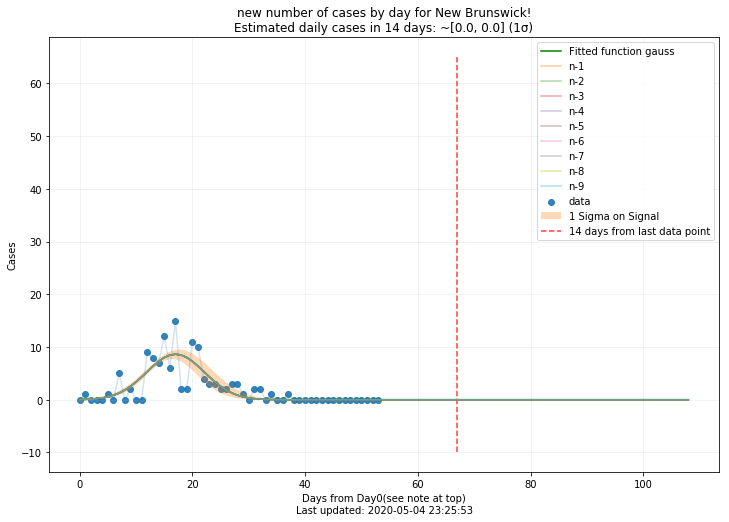

sigma+: 118.0
n+1: 117.0
Sigma-: 117.0
----

params PY:  [117.20514093   0.29383546  18.14113028]
PY sigma:  [0.48779828 0.00755053 0.10127373]
max cases:  117.0
infection point:  18.0
infection point date:  2020-02-18


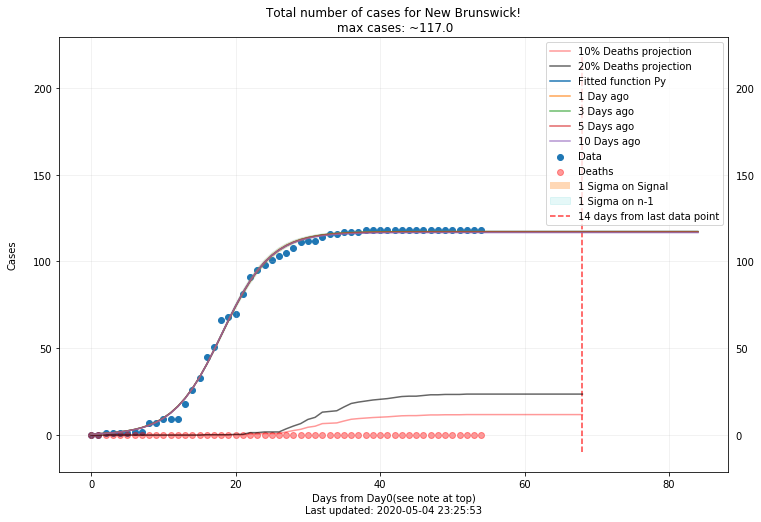

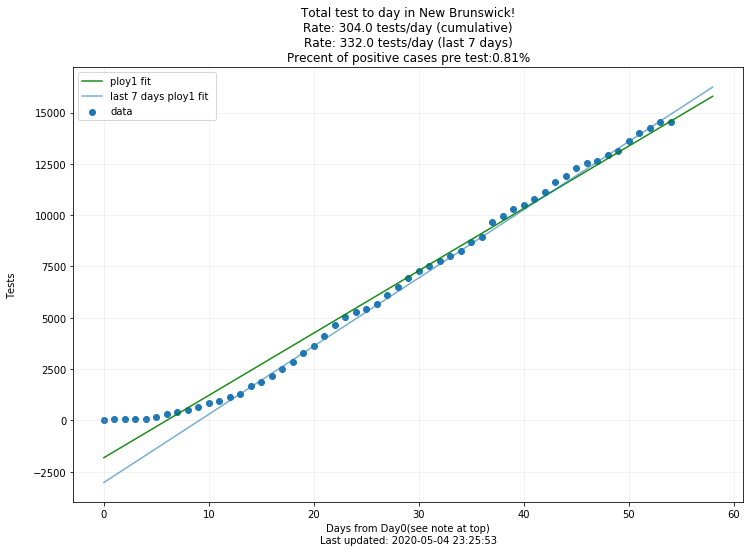

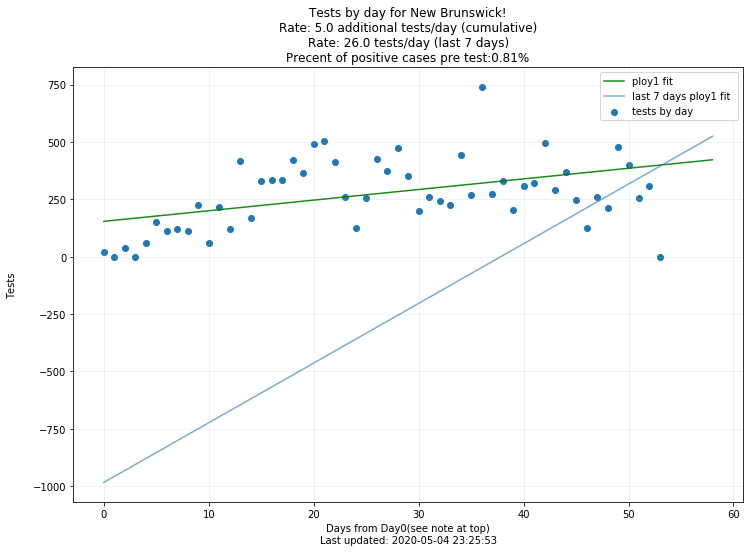

Precent of positive cases pre test: 0.81 %


------------- Newfoundland and Labrador-------------
cases:  [  0.   0.   0.   0.   0.   0.   0.   0.   1.   3.   3.   3.   4.   4.
  67.  82. 102. 120. 135. 148. 152. 175. 183. 183. 195. 217. 226. 228.
 232. 236. 239. 241. 242. 244. 244. 247. 252. 256. 257. 257. 257. 257.
 256. 256. 256. 257. 258. 258. 258. 258. 258. 259. 259. 259. 259.]


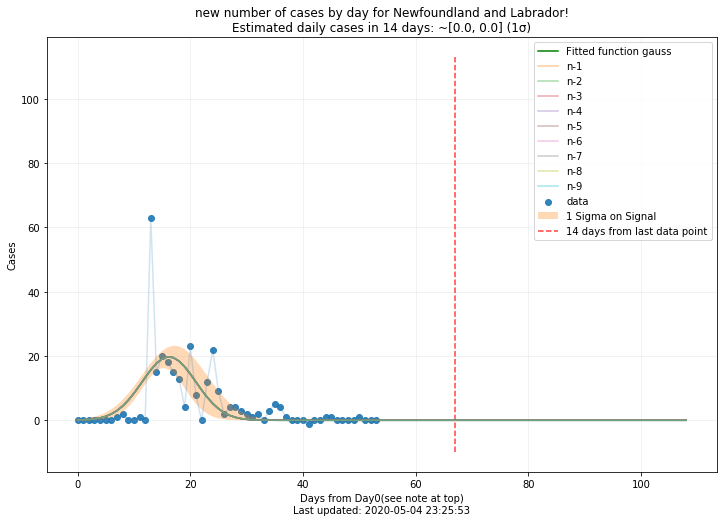

sigma+: 256.0
n+1: 254.0
Sigma-: 251.0
----

params PY:  [253.61127712   0.29580019  18.48398647]
PY sigma:  [2.28545047 0.0164256  0.2174475 ]
max cases:  254.0
infection point:  18.0
infection point date:  2020-02-18


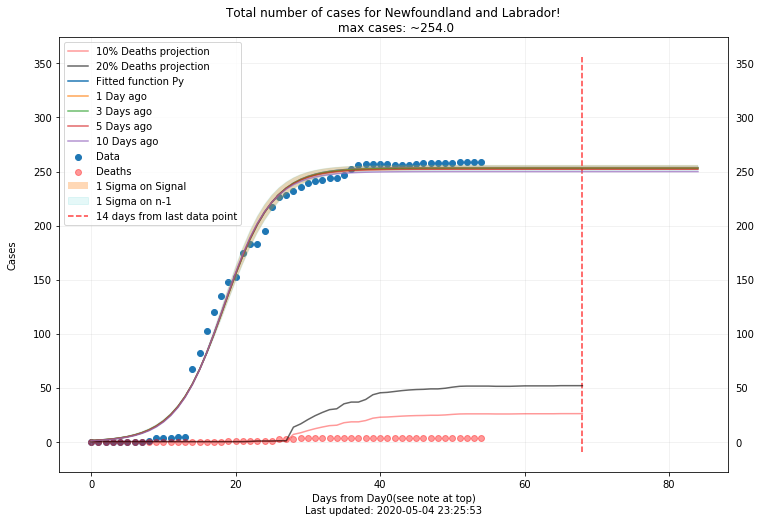

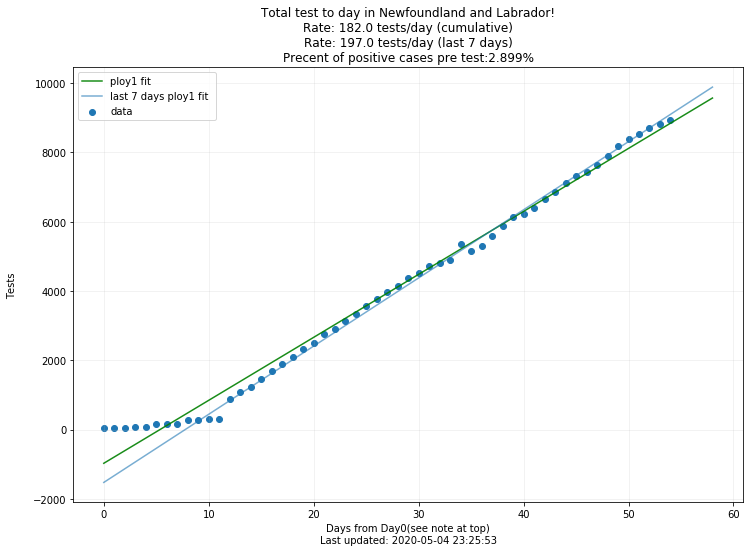

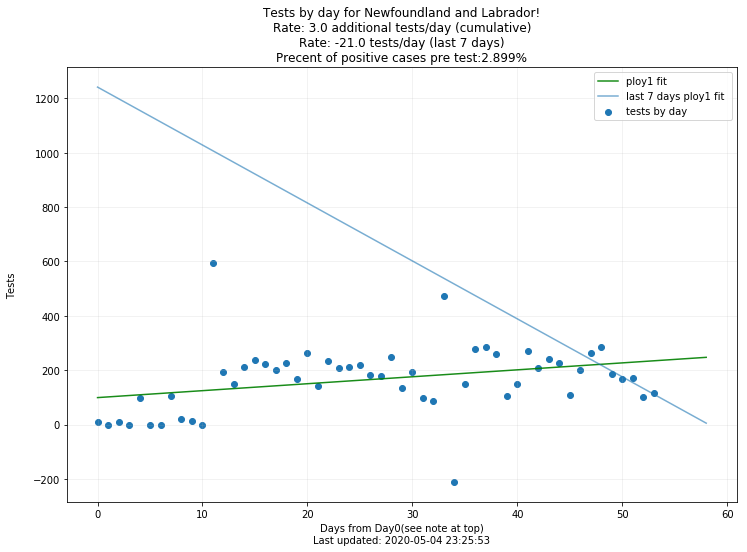

Precent of positive cases pre test: 2.899 %


------------- Nova Scotia-------------
cases:  [  0.   0.   0.   0.   0.   0.   0.   1.   5.   5.   9.  28.  41.  51.
  68.  73.  90. 110. 122. 127. 147. 173. 193. 207. 236. 262. 293. 310.
 342. 373. 407. 428. 445. 474. 517. 549. 579. 606. 649. 675. 721. 737.
 772. 827. 850. 865. 873. 900. 915. 935. 947. 959. 963. 971. 985.]


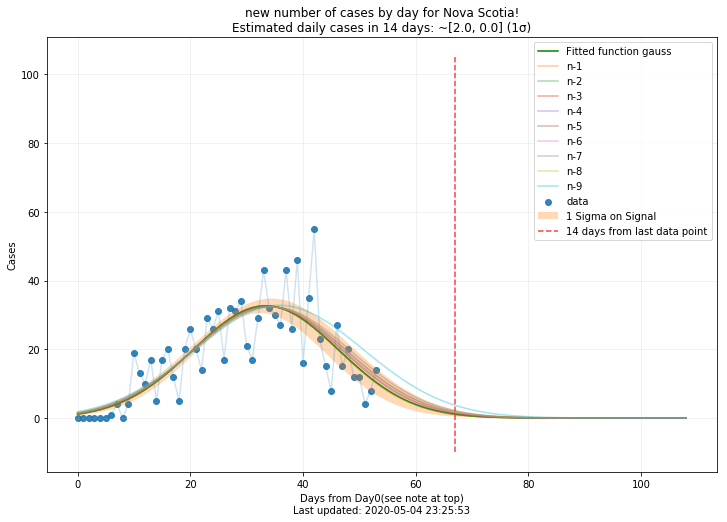

sigma+: 1012.0
n+1: 996.0
Sigma-: 979.0
----

params PY:  [1.06066034e+03 1.31013192e-01 3.41699231e+01]
PY sigma:  [1.20501859e+01 2.70827451e-03 2.55546107e-01]
max cases:  1061.0
infection point:  34.0
infection point date:  2020-03-05


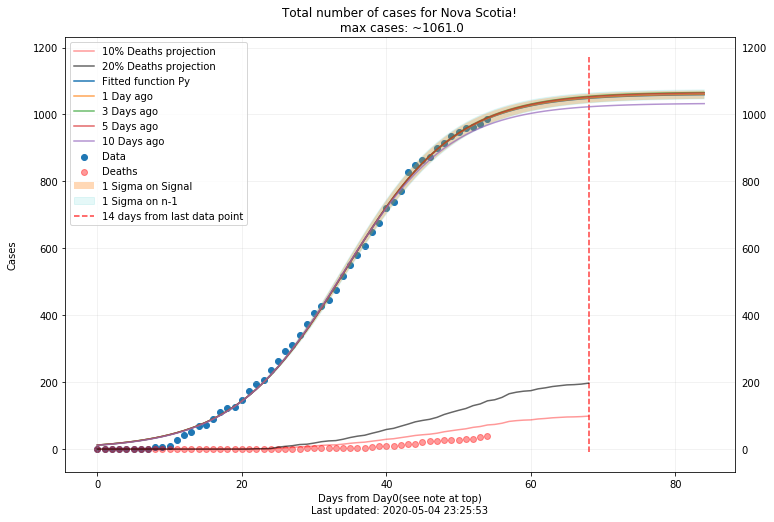

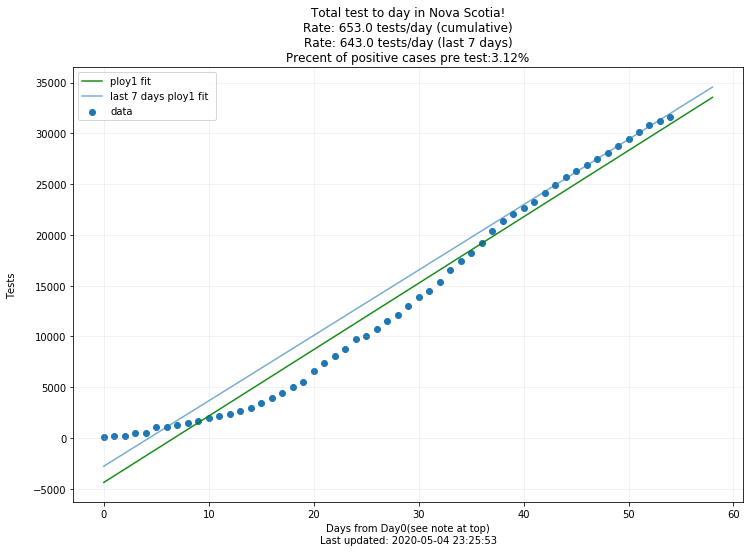

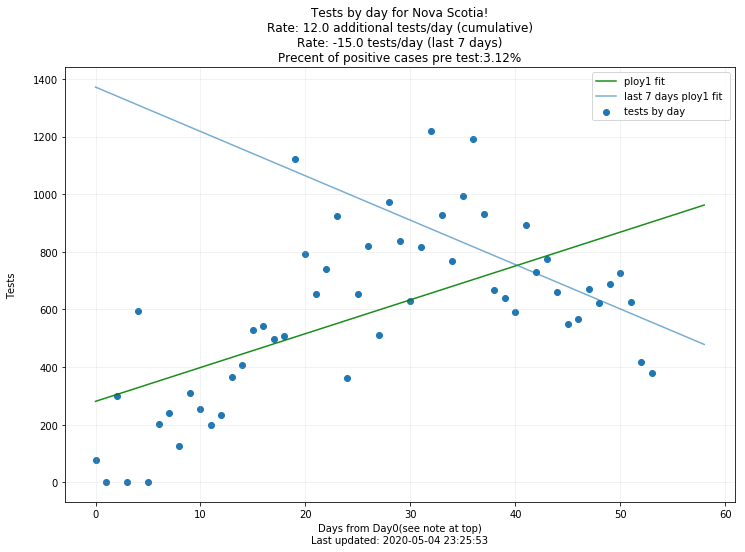

Precent of positive cases pre test: 3.12 %


------------- Ontario-------------
cases:  [3.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 4.0000e+00 4.0000e+00
 5.0000e+00 6.0000e+00 8.0000e+00 1.5000e+01 2.0000e+01 2.2000e+01
 2.8000e+01 2.8000e+01 3.1000e+01 3.4000e+01 4.2000e+01 5.9000e+01
 7.9000e+01 7.9000e+01 1.0300e+02 1.4500e+02 1.7700e+02 1.8900e+02
 2.5800e+02 3.1100e+02 3.7700e+02 4.2500e+02 5.0300e+02 5.8800e+02
 6.8800e+02 8.5800e+02 9.9300e+02 9.9300e+02 1.3550e+03 1.7060e+03
 1.9660e+03 2.3920e+03 2.7930e+03 3.2550e+03 3.6300e+03 4.0380e+03
 4.3470e+03 4.7260e+03 5.2760e+03 5.7590e+03 6.2370e+03 6.6480e+03
 7.0490e+03 7.4700e+03 7.9530e+03 8.4470e+03 8.9610e+03 9.5250e+03
 1.0010e+04 1.0578e+04 1.1184e+04 1.1735e+04 1.2245e+04 1.2879e+04
 1.3519e+04 1.3995e+04 1.4432e+04 1.4856e+04 1.5381e+04 1.5728e+04
 1.6187e+04 1.6608e+04 1.7119e+04 1.7553e+04 1.7923e+04]


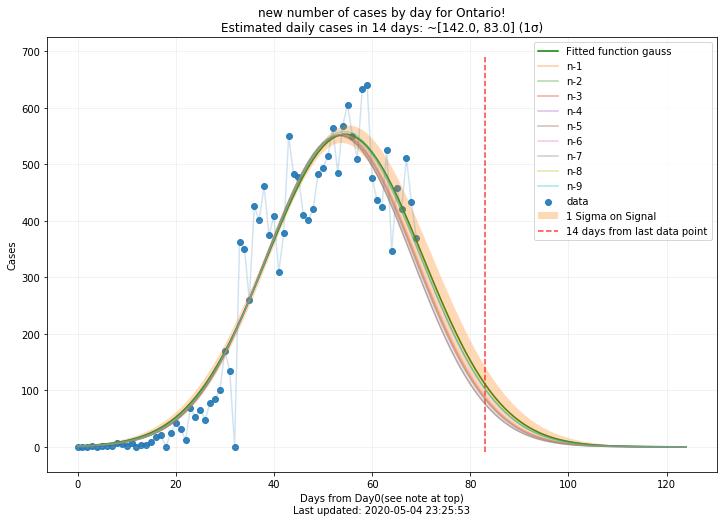

sigma+: 18141.0
n+1: 17698.0
Sigma-: 17253.0
----

params PY:  [1.98706847e+04 1.19884914e-01 5.35026756e+01]
PY sigma:  [3.10517678e+02 2.57317060e-03 3.46956523e-01]
max cases:  19871.0
infection point:  54.0
infection point date:  2020-03-25


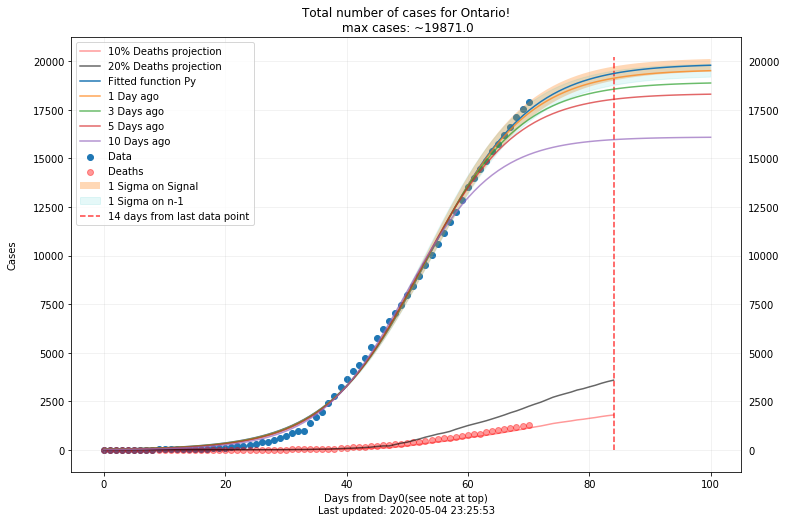

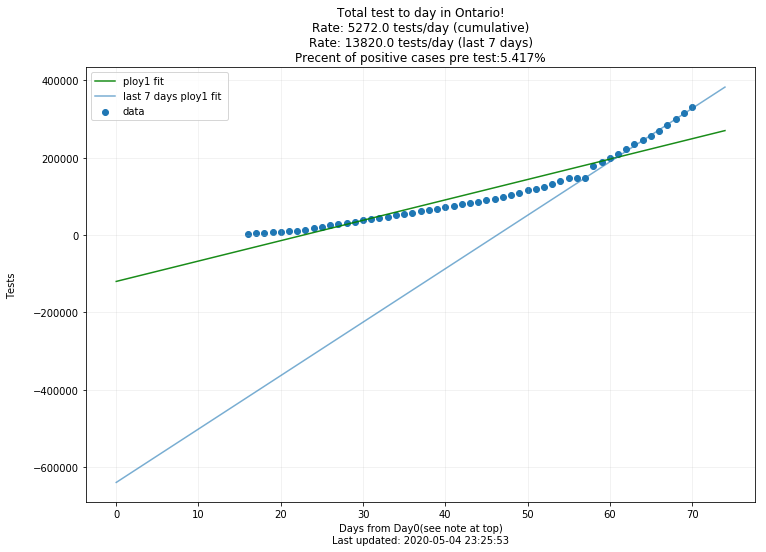

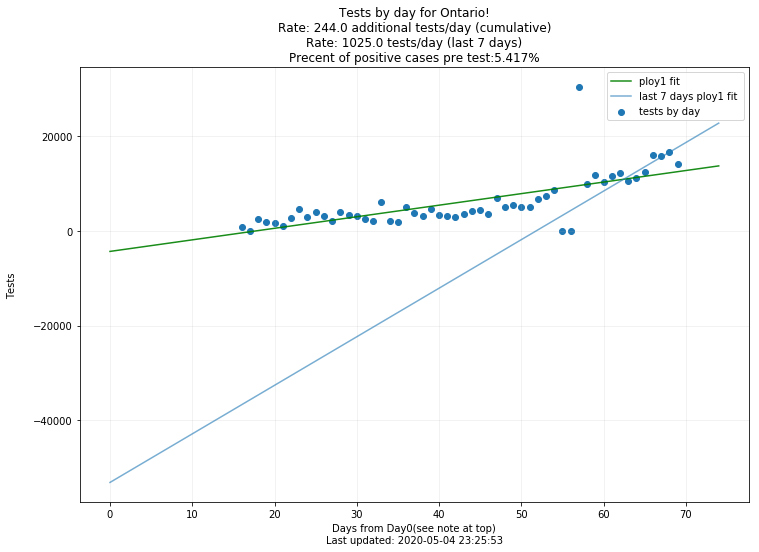

Precent of positive cases pre test: 5.417 %


------------- Prince Edward Island-------------
cases:  [ 0.  0.  0.  0.  1.  1.  1.  1.  2.  2.  2.  3.  3.  3.  5.  9. 11. 11.
 11. 18. 21. 21. 22. 22. 22. 22. 22. 22. 24. 25. 25. 25. 25. 25. 25. 26.
 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 27. 27. 27. 27. 27. 27.
 27.]


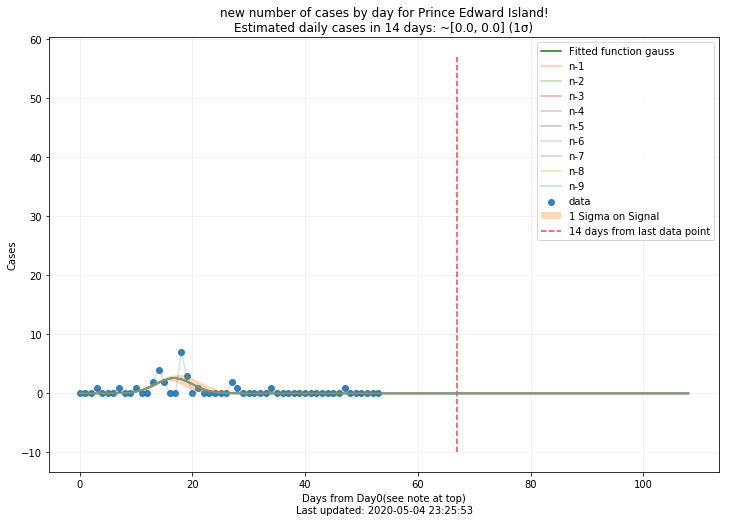

sigma+: 26.0
n+1: 26.0
Sigma-: 26.0
----

params PY:  [25.94343801  0.31900459 17.53005792]
PY sigma:  [0.22281905 0.01802127 0.20465692]
max cases:  26.0
infection point:  18.0
infection point date:  2020-02-18


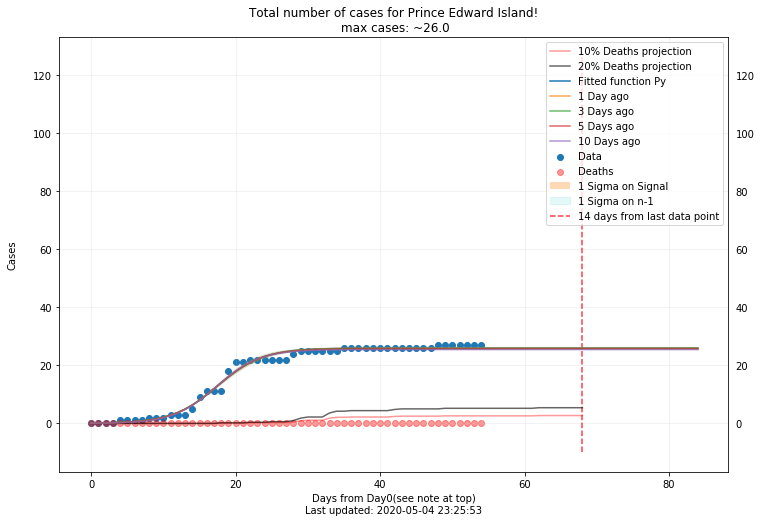

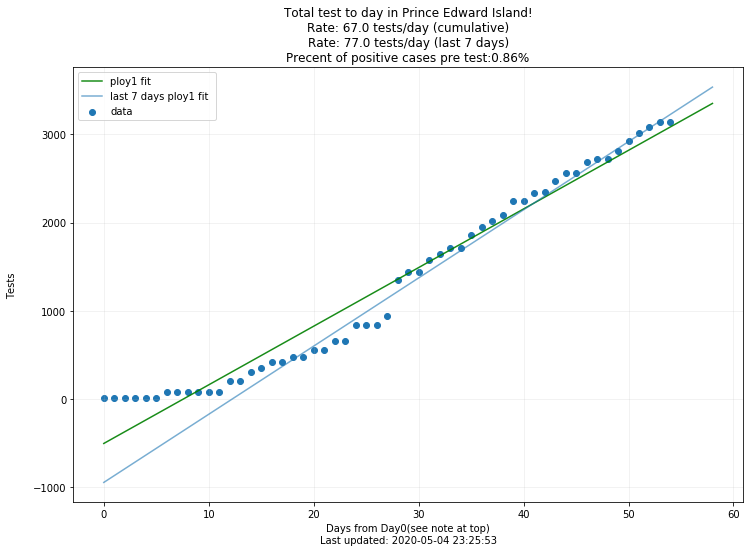

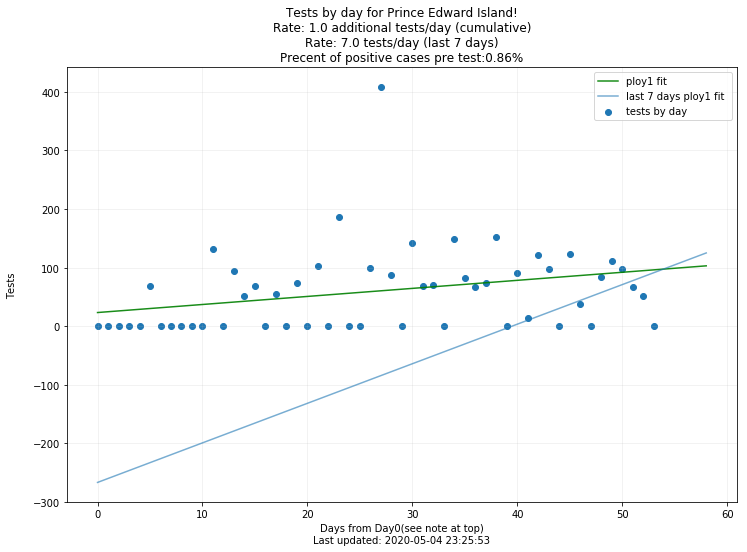

Precent of positive cases pre test: 0.86 %


------------- Quebec-------------
cases:  [1.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 3.0000e+00
 4.0000e+00 7.0000e+00 1.3000e+01 1.7000e+01 1.7000e+01 2.4000e+01
 3.9000e+01 5.0000e+01 7.4000e+01 1.2100e+02 1.3900e+02 2.0200e+02
 2.2100e+02 2.2100e+02 2.2100e+02 1.3390e+03 1.6290e+03 2.0210e+03
 2.4980e+03 2.8400e+03 3.4300e+03 4.1620e+03 4.6110e+03 5.5180e+03
 6.1010e+03 6.9970e+03 7.9440e+03 8.5800e+03 9.3400e+03 1.0031e+04
 1.0912e+04 1.1677e+04 1.2292e+04 1.2846e+04 1.3557e+04 1.4248e+04
 1.4860e+04 1.5857e+04 1.6798e+04 1.7521e+04 1.8357e+04 1.9319e+04
 2.0126e+04 2.0965e+04 2.1838e+04 2.2616e+04 2.3267e+04 2.4107e+04
 2.4982e+04 2.5757e+04 2.6594e+04 2.7538e+04 2.8648e+04 2.9656e+04
 3.1865e+04 3.2623e+04]


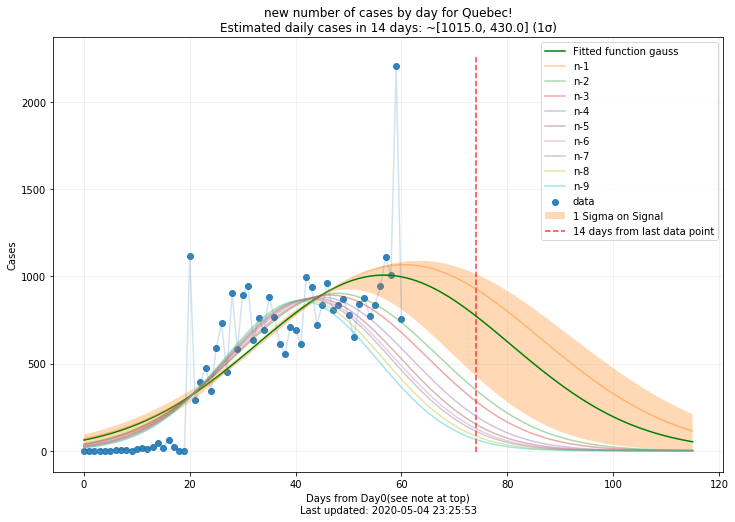

sigma+: 32487.0
n+1: 30749.0
Sigma-: 29003.0
----

params PY:  [3.53354797e+04 1.11227036e-01 4.48922821e+01]
PY sigma:  [1.21925448e+03 4.79618295e-03 7.99693775e-01]
max cases:  35335.0
infection point:  45.0
infection point date:  2020-03-16


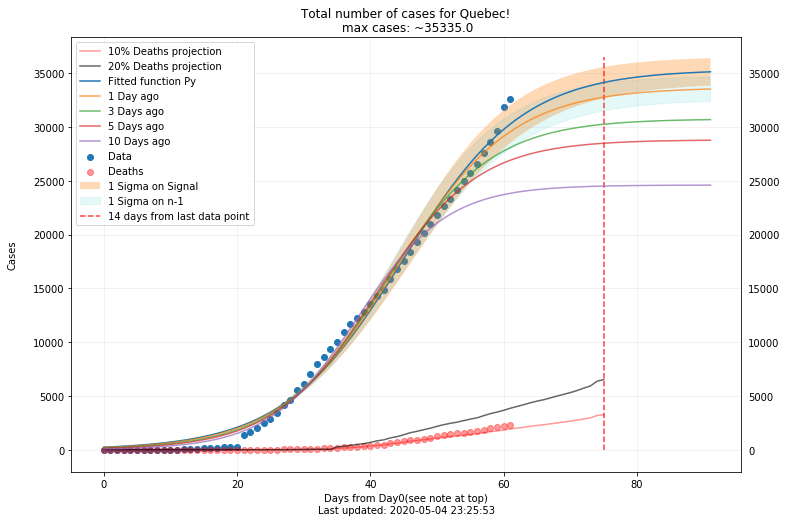

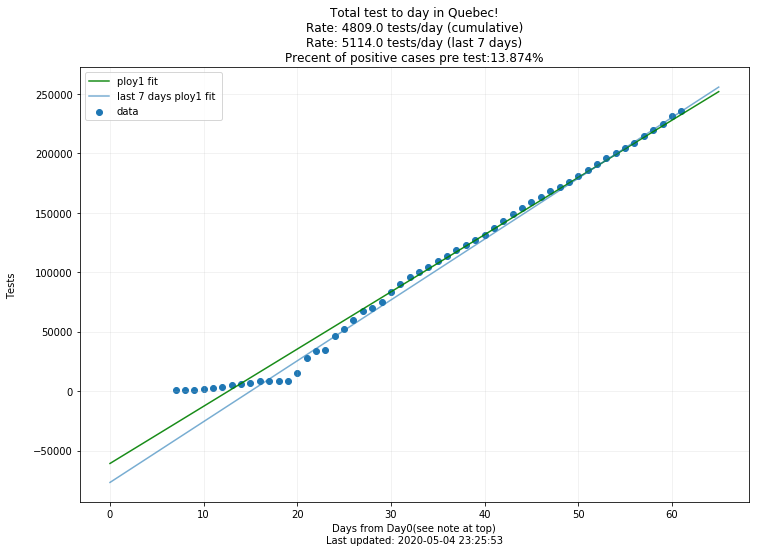

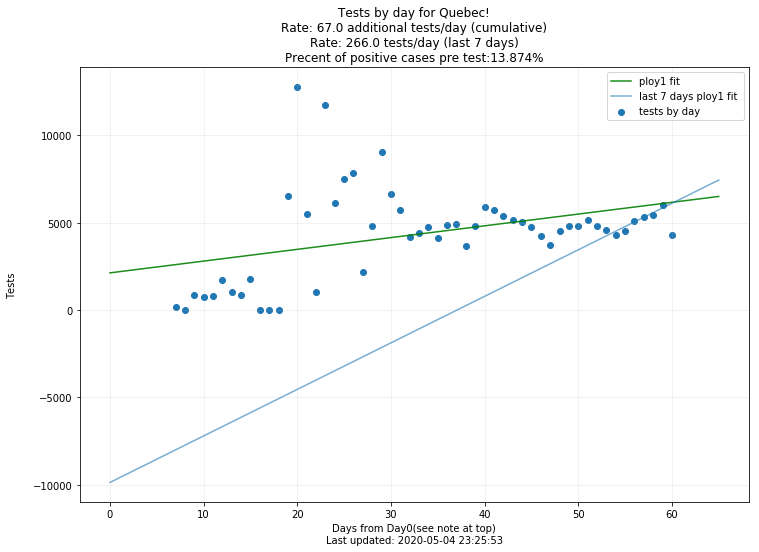

Precent of positive cases pre test: 13.874 %


------------- Saskatchewan-------------
cases:  [  0.   0.   0.   0.   0.   1.   2.   2.   8.   8.  25.  33.  65.  72.
  86.  95. 104. 134. 134. 175. 184. 193. 206. 220. 231. 249. 253. 260.
 271. 278. 285. 289. 296. 300. 301. 304. 305. 306. 310. 314. 316. 320.
 326. 331. 341. 347. 353. 365. 366. 383. 389. 415. 421. 433. 467.]


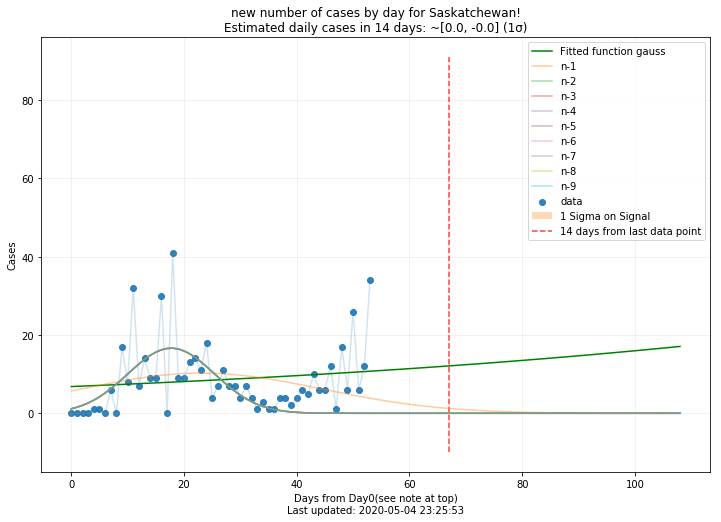

sigma+: 383.0
n+1: 373.0
Sigma-: 362.0
----

params PY:  [3.75357178e+02 1.50769987e-01 2.21980167e+01]
PY sigma:  [9.05178471 0.0124698  0.66495042]
max cases:  375.0
infection point:  22.0
infection point date:  2020-02-22


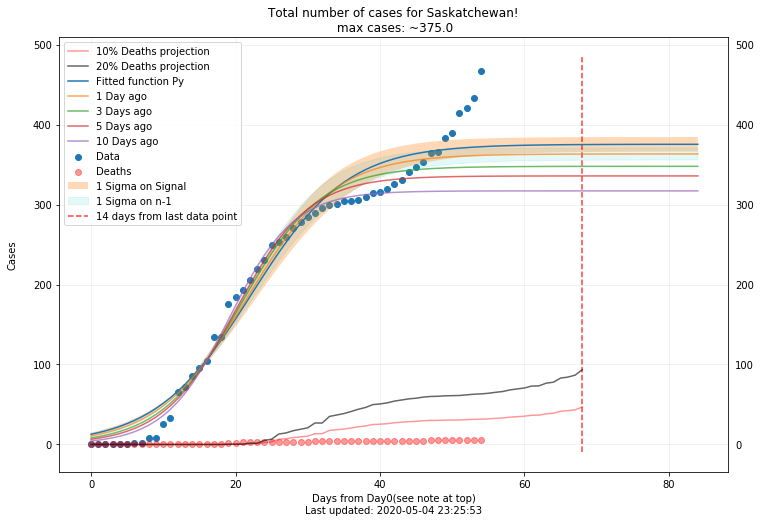

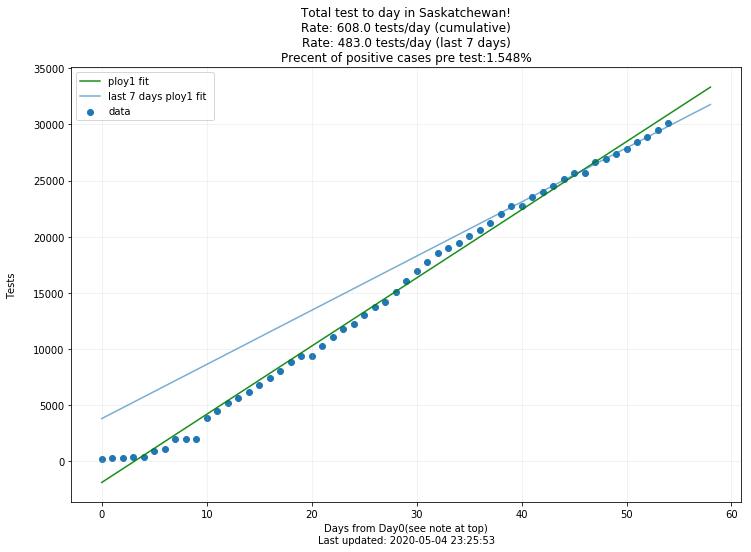

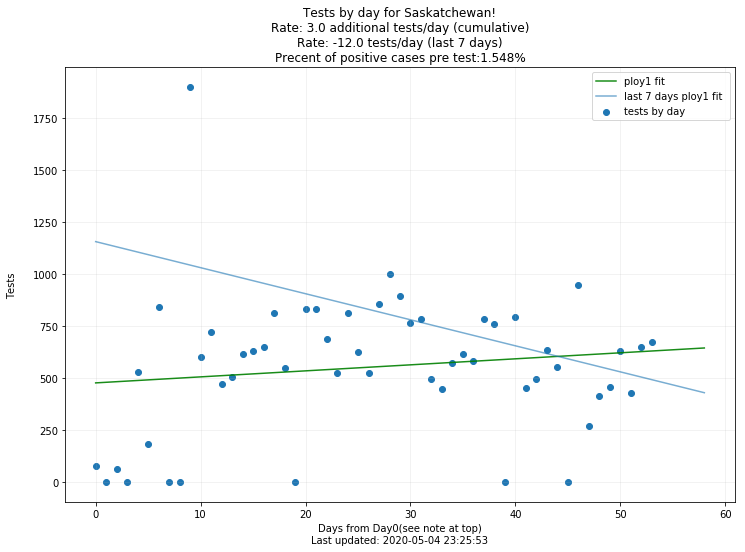

Precent of positive cases pre test: 1.548 %


In [183]:
%matplotlib inline
# %time
global last_updated
last_updated="Last updated: "+datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print ("Last updated: "+datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


note="""
    Waqar Muhammad - mwaqar@snolab.ca
    
    NOTE:
    All of the following was data is from Health Canada. 
    The CDF fit is a logicitsts curve fit. 
    The PDF fit is a simple gaussian fit. 
    Day 0 is:
    -> 31-01-2020 for Canada 
    -> 08-03-2020 for AB
    -> 31-01-2020 for BC
    -> 11-03-2020 for MN
    -> 11-03-2020 for NB
    -> 11-03-2020 for NL
    -> 11-03-2020 for NS
    -> 31-01-2020 for ON
    -> 11-03-2020 for PEI
    -> 01-03-2020 for QC
    -> 11-03-2020 for SW"""
print(note)


# AllofCanada=[ "Canada","British Columbia", "Ontario", "Quebec"]
# AllofCanadaAbv=["Canada","BC","ON","QC"]

# AllofCanada=["Canada","Alberta","British Columbia", "Ontario", "Quebec"]
# AllofCanadaAbv=["Canada","AB","BC","ON","QC"]

AllofCanada=["Canada","Alberta","British Columbia", "Manitoba", "New Brunswick", 
              "Newfoundland and Labrador", "Nova Scotia", "Ontario", "Prince Edward Island", "Quebec", "Saskatchewan"]
AllofCanadaAbv=["Canada","AB","BC", "MN", "NB", 
              "NL", "NS", "ON", "PEI", "QC", "SK"]

AllofCanadaNoAB=["Canada","British Columbia", "Manitoba", "New Brunswick", 
              "Newfoundland and Labrador", "Nova Scotia", "Ontario", "Prince Edward Island", "Quebec", "Saskatchewan"]
AllofCanadaAbvNoAB=["Canada","BC", "MN", "NB", 
              "NL", "NS", "ON", "PEI", "QC", "SK"]

TheCruve(AllofCanada,AllofCanadaAbv,519000)

for i in AllofCanada:
    MakeMePrediction(i,519000)


    
    
    
    
    
    
    
    
